In [1]:
pip install pytrends --upgrade

Requirement already up-to-date: pytrends in c:\users\izabela\anaconda3\lib\site-packages (4.9.0)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pytrends
import time
import yfinance as yf
import numpy as np
import seaborn as sb
%matplotlib inline
#from datetime import datetime, timedelta 
#import mplfinance as mpf
from pytrends.request import TrendReq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
#from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression

In [2]:
#ustawianie parametrów do API PyTrends
pytrends = TrendReq(hl='en-US', tz=360)
pytrends2 = TrendReq(hl='en-US', tz=360)
#pytrends = TrendReq()
#pytrends = TrendReq(hl='en-US', tz=360, timeout=(10,25), proxies=['https://34.203.233.13:80',], retries=2, backoff_factor=0.1, requests_args={'verify':False})

### Lista z hasłami z Google Trends

In [3]:
#lista z hasłami wyszukiwania i timeframe'em - Google Trends
timeframe = "2018-01-01 2022-01-02"

#ponieważ liczby zainteresowania w wyszukiwaniu podane są względem najwyższego punktu na wykresie
#zostało określone hasło znajdujące się we wszystkich listach - aby dało się porównać częstotliwość wszystkich haseł
const = 'investment'

kw_list1 = [const, 'finance', 'stocks', 'gold price', 'taxes']
kw_list = [const, 'inflation', 'buy stocks', 'recession', 'crisis']
kw_list2 = [const, 'partnership',  'NYSE', 'poverty', 'sell stocks']
kw_list3 = [const, 'profits', 'consume', 'entrepreneurship', 'dividends']
kw_list4 = [const, 'GDP', 'bull market', 'rents', 'sell stocks']
# lista z hasłami najczęściej wyszukiwanymi albo z największymi nieregularnościami:
kw_list5 = [const, 'credit', 'dow', 'unemployment', 'gold price'] 

#lista z listami haseł
full_list = [kw_list, kw_list1, kw_list2, kw_list3, kw_list4, kw_list5]

### Pobieranie danych z Google Trends, 
### sprowadzenie liczby wyszukiwań do jednej skali względem hasła "investment"

(Częste zdarzenie - jeśli poniższy kod nie zadziała w pełni i pojawi się error 429, to oznacza, że google blokuje i uznało nas za bota ze wzgledu na dużą ilość wyszukiwań w krótkim czasie. Wyłączenie jupyter notebooka, włączenie ponownie i puszczenie kodu od nowa działa.)

TooManyRequestsError: The request failed: Google returned a response with code 429

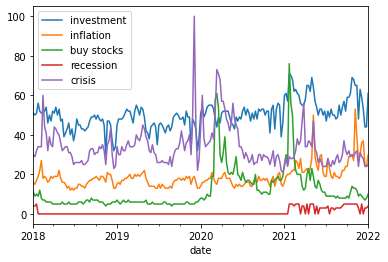

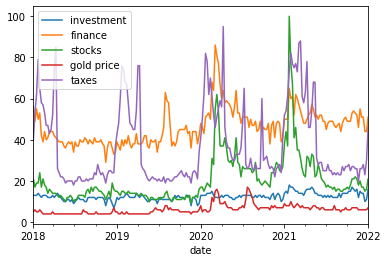

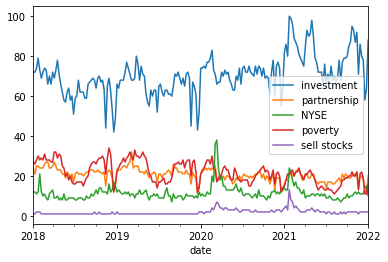

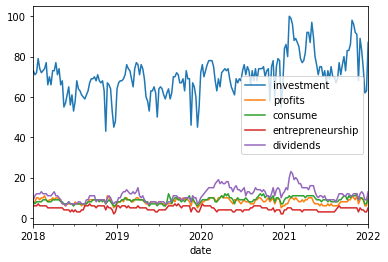

In [5]:
list_avg = list()
list_norm = list()
avg = []
df = []
df_trends = []
df_norm = []

# iterowanie po liście z listami haseł
for lst in full_list:
    
    # iterowanie haseł w kolejnych listach
    for sv in lst:
        pytrends.build_payload(lst, cat=0, timeframe=timeframe, geo='US', gprop='')
        df = pytrends.interest_over_time().drop('isPartial', axis=1)
        time.sleep(10)
    df_trends.append(df)
    
     
    #print(df.head(3))
    #wykresy dla każdej listy haseł
    df.plot()
    
    # średnia hasła stałego we wszystkch listach
    avg = df[const].mean(axis=0)
    
    # tworzenie listy średnich w kolejnych df dla stałego hasła
    list_avg.append(avg)


print(list_avg)    


# obliczanie czynnika normalizacji/ujednolicenia w celu przyszłego przeskalowania danych
norm_factor = list()

for i in list_avg:
    # iloraz średniej stałego hasła z pierwszego df i średniej stałego hasła z kolejnego df
    norm_factor = list_avg[0]/i 
    list_norm.append(norm_factor)
    
print(list_norm)

#sprowadzenie liczby wyszukiwań do jednej skali
for i, df in zip(list_norm, df_trends):
    df_norm.append(round((df*i), 1))
#print(df_norm)

In [6]:
# Połączenie wszytskich zmiennych niezależnych w jedną ramkę danych
df_fin1 = pd.concat(df_norm, axis=1)
df_fin2 = df_fin1.loc[:,~df_fin1.columns.duplicated()].copy()
df_fin2.index = pd.to_datetime(df_fin2.index)
df_fin2.rename(columns={'date': 'Date'}, inplace=True)
df_fin2 = df_fin2.shift(periods=-6, freq="D") #zmiana dat, żeby potem zgadzała się z datami w danych giełdowych
df_fin2

ValueError: No objects to concatenate

<AxesSubplot:xlabel='date'>

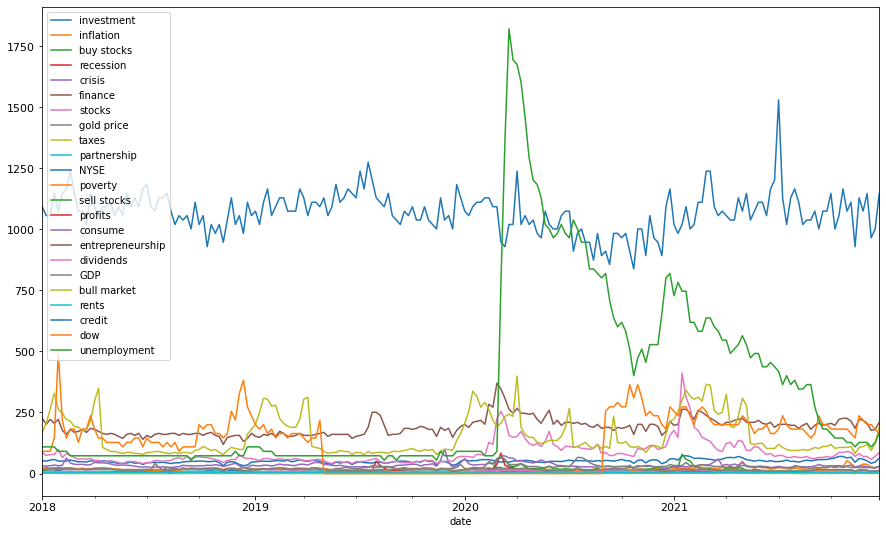

In [8]:
df_fin2.plot(figsize=(15,9), fontsize=11)

In [9]:
df_fin2.describe().round(2)

investment  inflation  buy stocks  recession  crisis  finance  stocks  \
count      209.00     209.00      209.00     209.00  209.00   209.00  209.00   
mean        50.96      19.21       12.15       7.68   34.36   191.24   83.44   
std          7.16       5.72       10.95       7.81    9.97    36.22   47.81   
min         32.00      12.00        4.00       2.00   22.00   119.20   37.00   
25%         47.00      16.00        6.00       5.00   28.00   160.40   53.50   
50%         51.00      18.00        8.00       6.00   32.00   189.20   65.80   
75%         54.00      21.00       16.00       8.00   37.00   209.70   98.70   
max         73.00      53.00       79.00      84.00  100.00   370.10  411.20   

       gold price   taxes  partnership  ...  profits  consume  \
count      209.00  209.00       209.00  ...   209.00   209.00   
mean        25.24  152.66        14.89  ...     5.99     6.40   
std          9.48   78.97         2.27  ...     1.01     1.04   
min         16.40   78.10         8.00  ...     3.60     3.60   
25%         16.40   94.60        13.90  ...     5.10     5.80   
50%         24.70  111.00        15.30  ...     5.80     6.60   
75%         28.80  205.60        16.10  ...     6.60     7.30   
max         69.90  398.90        21.20  ...     8.80     8.80   

       entrepreneurship  dividends     GDP  bull market   rents   credit  \
count             209.0     209.00  209.00       209.00  209.00   209.00   
mean                3.3       8.32   16.31         1.01    3.77  1069.22   
std                 0.8       2.33    4.67         0.66    0.57    82.38   
min                 1.5       4.40    8.00         0.70    2.20   837.40   
25%                 2.9       6.60   13.10         0.70    3.60  1019.50   
50%                 2.9       8.00   16.10         0.70    3.60  1074.10   
75%                 3.6       9.50   19.70         1.50    4.40  1128.70   
max                 5.1      16.80   41.60         7.30    5.10  1529.20   

          dow  unemployment  
count  209.00        209.00  
mean   127.53        330.64  
std    104.25        379.52  
min      0.00         54.60  
25%      0.00         72.80  
50%    145.60         91.00  
75%    200.30        527.90  
max    491.50       1820.50  

[8 rows x 23 columns]

In [19]:
'''
#Jeśli by działało poprawnie API:
start_date = '2017-12-17'
finish_date = '2022-01-03'
chosen_interval = '1wk'
ticker = 'DJI'


# pobieranie danych historycznych tygodniowych dla DJI
df_yf = yf.download('DJI', interval = chosen_interval, 
                     start = start_date, end = finish_date,
                     progress = False) # progress = False żeby nie pokazywało postępu ściągania danych
                     
#to też nie działa dla df2: start = '2019-06-09', end = '2019-12-22'                      
start_date = '2017-12-17'
finish_date = '2021-12-28'
chosen_interval = '1wk'
ticker = 'DJI'


# pobieranie danych historycznych tygodniowych dla DJI
df1 = yf.download('DJI', interval = chosen_interval, 
                     start = start_date, end = '2019-06-04',
                     progress = False) # progress = False żeby nie pokazywało postępu ściągania danych
df2 = yf.download('DJI', interval = chosen_interval, 
                     start = '2019-06-09', end = '2019-12-22',
                     progress = False)
df3 = yf.download('DJI', interval = chosen_interval, 
                     start = '2019-12-31', end = '2021-12-28',
                     progress = False)
df1.info()
df2.info()
df3.info()
'''

"\n#Jeśli by działało poprawnie API:\nstart_date = '2017-12-17'\nfinish_date = '2022-01-03'\nchosen_interval = '1wk'\nticker = 'DJI'\n\n\n# pobieranie danych historycznych tygodniowych dla DJI\ndf_yf = yf.download('DJI', interval = chosen_interval, \n                     start = start_date, end = finish_date,\n                     progress = False) # progress = False żeby nie pokazywało postępu ściągania danych\n                     \n#to też nie działa dla df2: start = '2019-06-09', end = '2019-12-22'                      \nstart_date = '2017-12-17'\nfinish_date = '2021-12-28'\nchosen_interval = '1wk'\nticker = 'DJI'\n\n\n# pobieranie danych historycznych tygodniowych dla DJI\ndf1 = yf.download('DJI', interval = chosen_interval, \n                     start = start_date, end = '2019-06-04',\n                     progress = False) # progress = False żeby nie pokazywało postępu ściągania danych\ndf2 = yf.download('DJI', interval = chosen_interval, \n                     start = '2019-06

### Wczytywanie danych giełdowych dla indeksu Dow Jones

In [10]:
df_excel = pd.read_excel('djia.xlsx')
df_excel.rename(columns={'Date': 'date'})
df_excel.set_index('Date', inplace=True)
df_excel.index = pd.to_datetime(df_excel.index)
df_excel = df_excel.sort_index(ascending=True)
df_excel.info() #upewnienie się, że dane zostały wczytane jako float/int, a nie object
df_excel

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 211 entries, 2017-12-25 to 2022-01-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       211 non-null    float64
 1   High       211 non-null    float64
 2   Low        211 non-null    float64
 3   Close      211 non-null    float64
 4   Adj Close  211 non-null    float64
 5   Volume     211 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 11.5 KB


Open      High       Low     Close  Adj Close      Volume
Date                                                                     
2017-12-25  24715.84  24871.66  24708.42  24719.22   24719.22   905900000
2018-01-01  24809.35  25299.79  24741.70  25295.87   25295.87  1559220000
2018-01-08  25308.40  25810.43  25235.41  25803.19   25803.19  1739570000
2018-01-15  25987.62  26153.42  25702.99  26071.72   26071.72  2207020000
2018-01-22  26025.32  26616.71  25974.65  26616.71   26616.71  2262650000
...              ...       ...       ...       ...        ...         ...
2021-12-06  34633.43  35982.69  34633.43  35970.99   35970.99  1993530000
2021-12-13  35958.93  36189.83  35284.26  35365.44   35365.44  2530830000
2021-12-20  35222.12  36060.99  34665.50  35950.56   35950.56  1262020000
2021-12-27  35954.48  36306.61  35954.48  36302.38   36302.38   244350000
2022-01-03  36321.59  36595.82  36246.45  36585.06   36585.06   347930000

[211 rows x 6 columns]

### Ramka danych do dwóch modeli, gdzie chcemy sprawdzić, czy możemy prognozować zmiany w cenie indeksu giełdowego za pomocą haseł wyszukiwanych w Google z:
#### 1) tego samego tygodnia co notowania indeksu
#### 2) tygodnia poprzedzającego notowania indeksu

In [11]:
#df_ex = df_excel.assign(percentage_change = (df_excel['Close'] - df_excel['Open']) / df_excel['Open'])\
#.round(4).assign(percentage_change_adj = (df_excel['Adj Close'] - df_excel['Open']) / df_excel['Open']).round(4)

#kolumna weekly_return to różnica w cenie Adj Close między dwoma kolejnymi tygodniami
df_ex = df_excel.assign(weekly_return = df_excel['Adj Close'].pct_change())

In [12]:
# shifted return -> zakładamy, że wyszukiwania mają wpływ na przyszły tydzień, nie obecny
df_ex1 = df_ex.assign(shifted_return = df_ex['weekly_return'].shift(periods=-1))
df_ex1

Open      High       Low     Close  Adj Close      Volume  \
Date                                                                        
2017-12-25  24715.84  24871.66  24708.42  24719.22   24719.22   905900000   
2018-01-01  24809.35  25299.79  24741.70  25295.87   25295.87  1559220000   
2018-01-08  25308.40  25810.43  25235.41  25803.19   25803.19  1739570000   
2018-01-15  25987.62  26153.42  25702.99  26071.72   26071.72  2207020000   
2018-01-22  26025.32  26616.71  25974.65  26616.71   26616.71  2262650000   
...              ...       ...       ...       ...        ...         ...   
2021-12-06  34633.43  35982.69  34633.43  35970.99   35970.99  1993530000   
2021-12-13  35958.93  36189.83  35284.26  35365.44   35365.44  2530830000   
2021-12-20  35222.12  36060.99  34665.50  35950.56   35950.56  1262020000   
2021-12-27  35954.48  36306.61  35954.48  36302.38   36302.38   244350000   
2022-01-03  36321.59  36595.82  36246.45  36585.06   36585.06   347930000   

            weekly_return  shifted_return  
Date                                       
2017-12-25            NaN        0.023328  
2018-01-01       0.023328        0.020055  
2018-01-08       0.020055        0.010407  
2018-01-15       0.010407        0.020903  
2018-01-22       0.020903       -0.041168  
...                   ...             ...  
2021-12-06       0.040223       -0.016834  
2021-12-13      -0.016834        0.016545  
2021-12-20       0.016545        0.009786  
2021-12-27       0.009786        0.007787  
2022-01-03       0.007787             NaN  

[211 rows x 8 columns]

In [15]:
#sprawdzenie typów danych
df_ex.info()
df_fin2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 211 entries, 2017-12-25 to 2022-01-03
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           211 non-null    float64
 1   High           211 non-null    float64
 2   Low            211 non-null    float64
 3   Close          211 non-null    float64
 4   Adj Close      211 non-null    float64
 5   Volume         211 non-null    int64  
 6   weekly_return  210 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 13.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2018-01-01 to 2021-12-27
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   investment        209 non-null    float64
 1   inflation         209 non-null    float64
 2   buy stocks        209 non-null    float64
 3   recession         209 non-null    float64
 4   crisis            2

In [127]:
#połączenie zmiennych niezależnych i zależnej
df_merged = df_fin2.join(df_ex['weekly_return'].dropna(), how='right') #todo. concat poprawne, bo wtedy mam wszystkie indexes
df_merged = df_merged.dropna()

<AxesSubplot:xlabel='Date'>

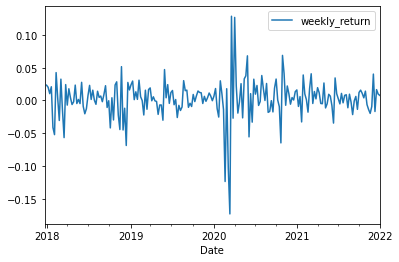

In [91]:
df_ex.plot.line(y='weekly_return')

In [92]:
df_merged['weekly_return'].describe().round(4)

count    209.0000
mean       0.0023
std        0.0298
min       -0.1730
25%       -0.0089
50%        0.0040
75%        0.0161
max        0.1284
Name: weekly_return, dtype: float64

In [ ]:
#outliers
#> 0.1, < 0.1

In [24]:
#sprawdzenie, czy da się przekształcić zmienną zależną na zmienną binarną (zamiast floata)
(df_ex['weekly_return']==0).sum()

0

In [128]:
# Przekodowanie zmiennej zależnej: jeśli cena wzrosła => 1, jeśli spadła => 0
df_merged.loc[(df_merged['weekly_return'] > 0 ), 'weekly_return'] = 1
df_merged.loc[(df_merged['weekly_return'] < 0 ), 'weekly_return'] = 0
df_merged['weekly_return'] = df_merged['weekly_return'].astype(int)
df_merged

investment  inflation  buy stocks  recession  crisis  finance  \
Date                                                                        
2018-01-01        53.0       16.0        11.0        4.0    31.0    226.2   
2018-01-08        51.0       16.0         9.0        4.0    31.0    201.5   
2018-01-15        55.0       18.0        10.0        5.0    32.0    222.0   
2018-01-22        58.0       19.0         9.0        6.0    35.0    205.6   
2018-01-29        51.0       25.0        13.0        7.0    32.0    222.0   
...                ...        ...         ...        ...     ...      ...   
2021-11-29        59.0       39.0         9.0        5.0    31.0    217.9   
2021-12-06        52.0       38.0         8.0        5.0    28.0    205.6   
2021-12-13        42.0       26.0         7.0        3.0    24.0    176.8   
2021-12-20        47.0       24.0         9.0        3.0    22.0    180.9   
2021-12-27        63.0       30.0        10.0        4.0    30.0    209.7   

            stocks  gold price  taxes  partnership  ...  consume  \
Date                                                ...            
2018-01-01    86.4        20.6  168.6         17.5  ...      5.8   
2018-01-08    74.0        24.7  205.6         15.3  ...      5.1   
2018-01-15    78.1        20.6  263.2         18.2  ...      5.8   
2018-01-22    78.1        20.6  329.0         18.2  ...      5.8   
2018-01-29    98.7        24.7  263.2         16.8  ...      5.8   
...            ...         ...    ...          ...  ...      ...   
2021-11-29    69.9        24.7  111.0         13.9  ...      7.3   
2021-12-06    69.9        24.7  119.2         13.1  ...      6.6   
2021-12-13    57.6        24.7   94.6          8.8  ...      5.1   
2021-12-20    69.9        24.7  123.4          8.8  ...      5.1   
2021-12-27    86.4        28.8  189.2         14.6  ...      7.3   

            entrepreneurship  dividends   GDP  bull market  rents  credit  \
Date                                                                        
2018-01-01               3.6        6.6  16.1          1.5    3.6  1092.3   
2018-01-08               4.4        7.3  16.1          1.5    3.6  1055.9   
2018-01-15               4.4        8.8  20.4          1.5    3.6  1055.9   
2018-01-22               5.1        8.8  22.6          1.5    3.6  1146.9   
2018-01-29               4.4        8.8  20.4          2.2    3.6  1074.1   
...                      ...        ...   ...          ...    ...     ...   
2021-11-29               2.9        9.5  16.1          1.5    3.6  1074.1   
2021-12-06               2.9        8.8  13.1          0.7    2.9  1146.9   
2021-12-13               2.2        6.6   8.0          0.7    2.9   964.9   
2021-12-20               2.2        6.6   8.0          0.7    2.2  1001.3   
2021-12-27               2.9        9.5  11.7          0.7    3.6  1146.9   

              dow  unemployment  weekly_return  
Date                                            
2018-01-01   91.0         109.2              1  
2018-01-08   91.0         109.2              1  
2018-01-15   91.0         109.2              1  
2018-01-22  145.6         109.2              1  
2018-01-29  491.5          91.0              0  
...           ...           ...            ...  
2021-11-29  218.5         127.4              0  
2021-12-06  200.3         127.4              1  
2021-12-13  200.3         109.2              0  
2021-12-20  182.1         127.4              1  
2021-12-27  163.8         163.8              1  

[209 rows x 24 columns]

In [ ]:
#plot histogram
#TODO

In [26]:
df_shifted = df_fin2.join(df_ex1['shifted_return'].dropna(), how='right')
df_shifted = df_shifted.dropna()

In [27]:
df_shifted['shifted_return'].describe().round(4)

count    209.0000
mean       0.0022
std        0.0298
min       -0.1730
25%       -0.0089
50%        0.0040
75%        0.0158
max        0.1284
Name: shifted_return, dtype: float64

In [28]:
# Przekodowanie zmiennej zależnej dla drugiego modelu
df_shifted.loc[(df_shifted['shifted_return'] > 0 ), 'shifted_return'] = 1
df_shifted.loc[(df_shifted['shifted_return'] < 0 ), 'shifted_return'] = 0
df_shifted['shifted_return'] = df_shifted['shifted_return'].astype(int)
df_shifted

investment  inflation  buy stocks  recession  crisis  finance  \
Date                                                                        
2018-01-01        53.0       16.0        11.0        4.0    31.0    226.2   
2018-01-08        51.0       16.0         9.0        4.0    31.0    201.5   
2018-01-15        55.0       18.0        10.0        5.0    32.0    222.0   
2018-01-22        58.0       19.0         9.0        6.0    35.0    205.6   
2018-01-29        51.0       25.0        13.0        7.0    32.0    222.0   
...                ...        ...         ...        ...     ...      ...   
2021-11-29        59.0       39.0         9.0        5.0    31.0    217.9   
2021-12-06        52.0       38.0         8.0        5.0    28.0    205.6   
2021-12-13        42.0       26.0         7.0        3.0    24.0    176.8   
2021-12-20        47.0       24.0         9.0        3.0    22.0    180.9   
2021-12-27        63.0       30.0        10.0        4.0    30.0    209.7   

            stocks  gold price  taxes  partnership  ...  consume  \
Date                                                ...            
2018-01-01    86.4        20.6  168.6         17.5  ...      5.8   
2018-01-08    74.0        24.7  205.6         15.3  ...      5.1   
2018-01-15    78.1        20.6  263.2         18.2  ...      5.8   
2018-01-22    78.1        20.6  329.0         18.2  ...      5.8   
2018-01-29    98.7        24.7  263.2         16.8  ...      5.8   
...            ...         ...    ...          ...  ...      ...   
2021-11-29    69.9        24.7  111.0         13.9  ...      7.3   
2021-12-06    69.9        24.7  119.2         13.1  ...      6.6   
2021-12-13    57.6        24.7   94.6          8.8  ...      5.1   
2021-12-20    69.9        24.7  123.4          8.8  ...      5.1   
2021-12-27    86.4        28.8  189.2         14.6  ...      7.3   

            entrepreneurship  dividends   GDP  bull market  rents  credit  \
Date                                                                        
2018-01-01               3.6        6.6  16.1          1.5    3.6  1092.3   
2018-01-08               4.4        7.3  16.1          1.5    3.6  1055.9   
2018-01-15               4.4        8.8  20.4          1.5    3.6  1055.9   
2018-01-22               5.1        8.8  22.6          1.5    3.6  1146.9   
2018-01-29               4.4        8.8  20.4          2.2    3.6  1074.1   
...                      ...        ...   ...          ...    ...     ...   
2021-11-29               2.9        9.5  16.1          1.5    3.6  1074.1   
2021-12-06               2.9        8.8  13.1          0.7    2.9  1146.9   
2021-12-13               2.2        6.6   8.0          0.7    2.9   964.9   
2021-12-20               2.2        6.6   8.0          0.7    2.2  1001.3   
2021-12-27               2.9        9.5  11.7          0.7    3.6  1146.9   

              dow  unemployment  shifted_return  
Date                                             
2018-01-01   91.0         109.2               1  
2018-01-08   91.0         109.2               1  
2018-01-15   91.0         109.2               1  
2018-01-22  145.6         109.2               0  
2018-01-29  491.5          91.0               0  
...           ...           ...             ...  
2021-11-29  218.5         127.4               1  
2021-12-06  200.3         127.4               0  
2021-12-13  200.3         109.2               1  
2021-12-20  182.1         127.4               1  
2021-12-27  163.8         163.8               1  

[209 rows x 24 columns]

In [118]:
df_shifted = df_shifted.drop(['stocks'], axis=1)

### Korelacja zmiennych

ten sam tydzień

In [74]:
corr = df_merged.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=np.bool))

<AxesSubplot:>

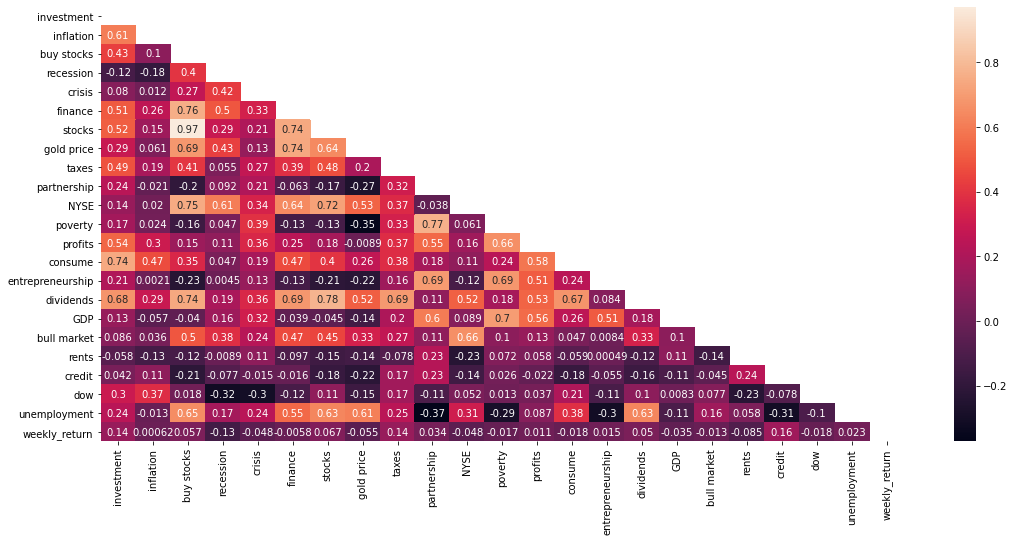

In [75]:
plt.figure(figsize=(18, 8))
sb.heatmap(corr, annot=True, mask=mask,
        xticklabels=corr.columns,
        yticklabels=corr.columns)
#https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

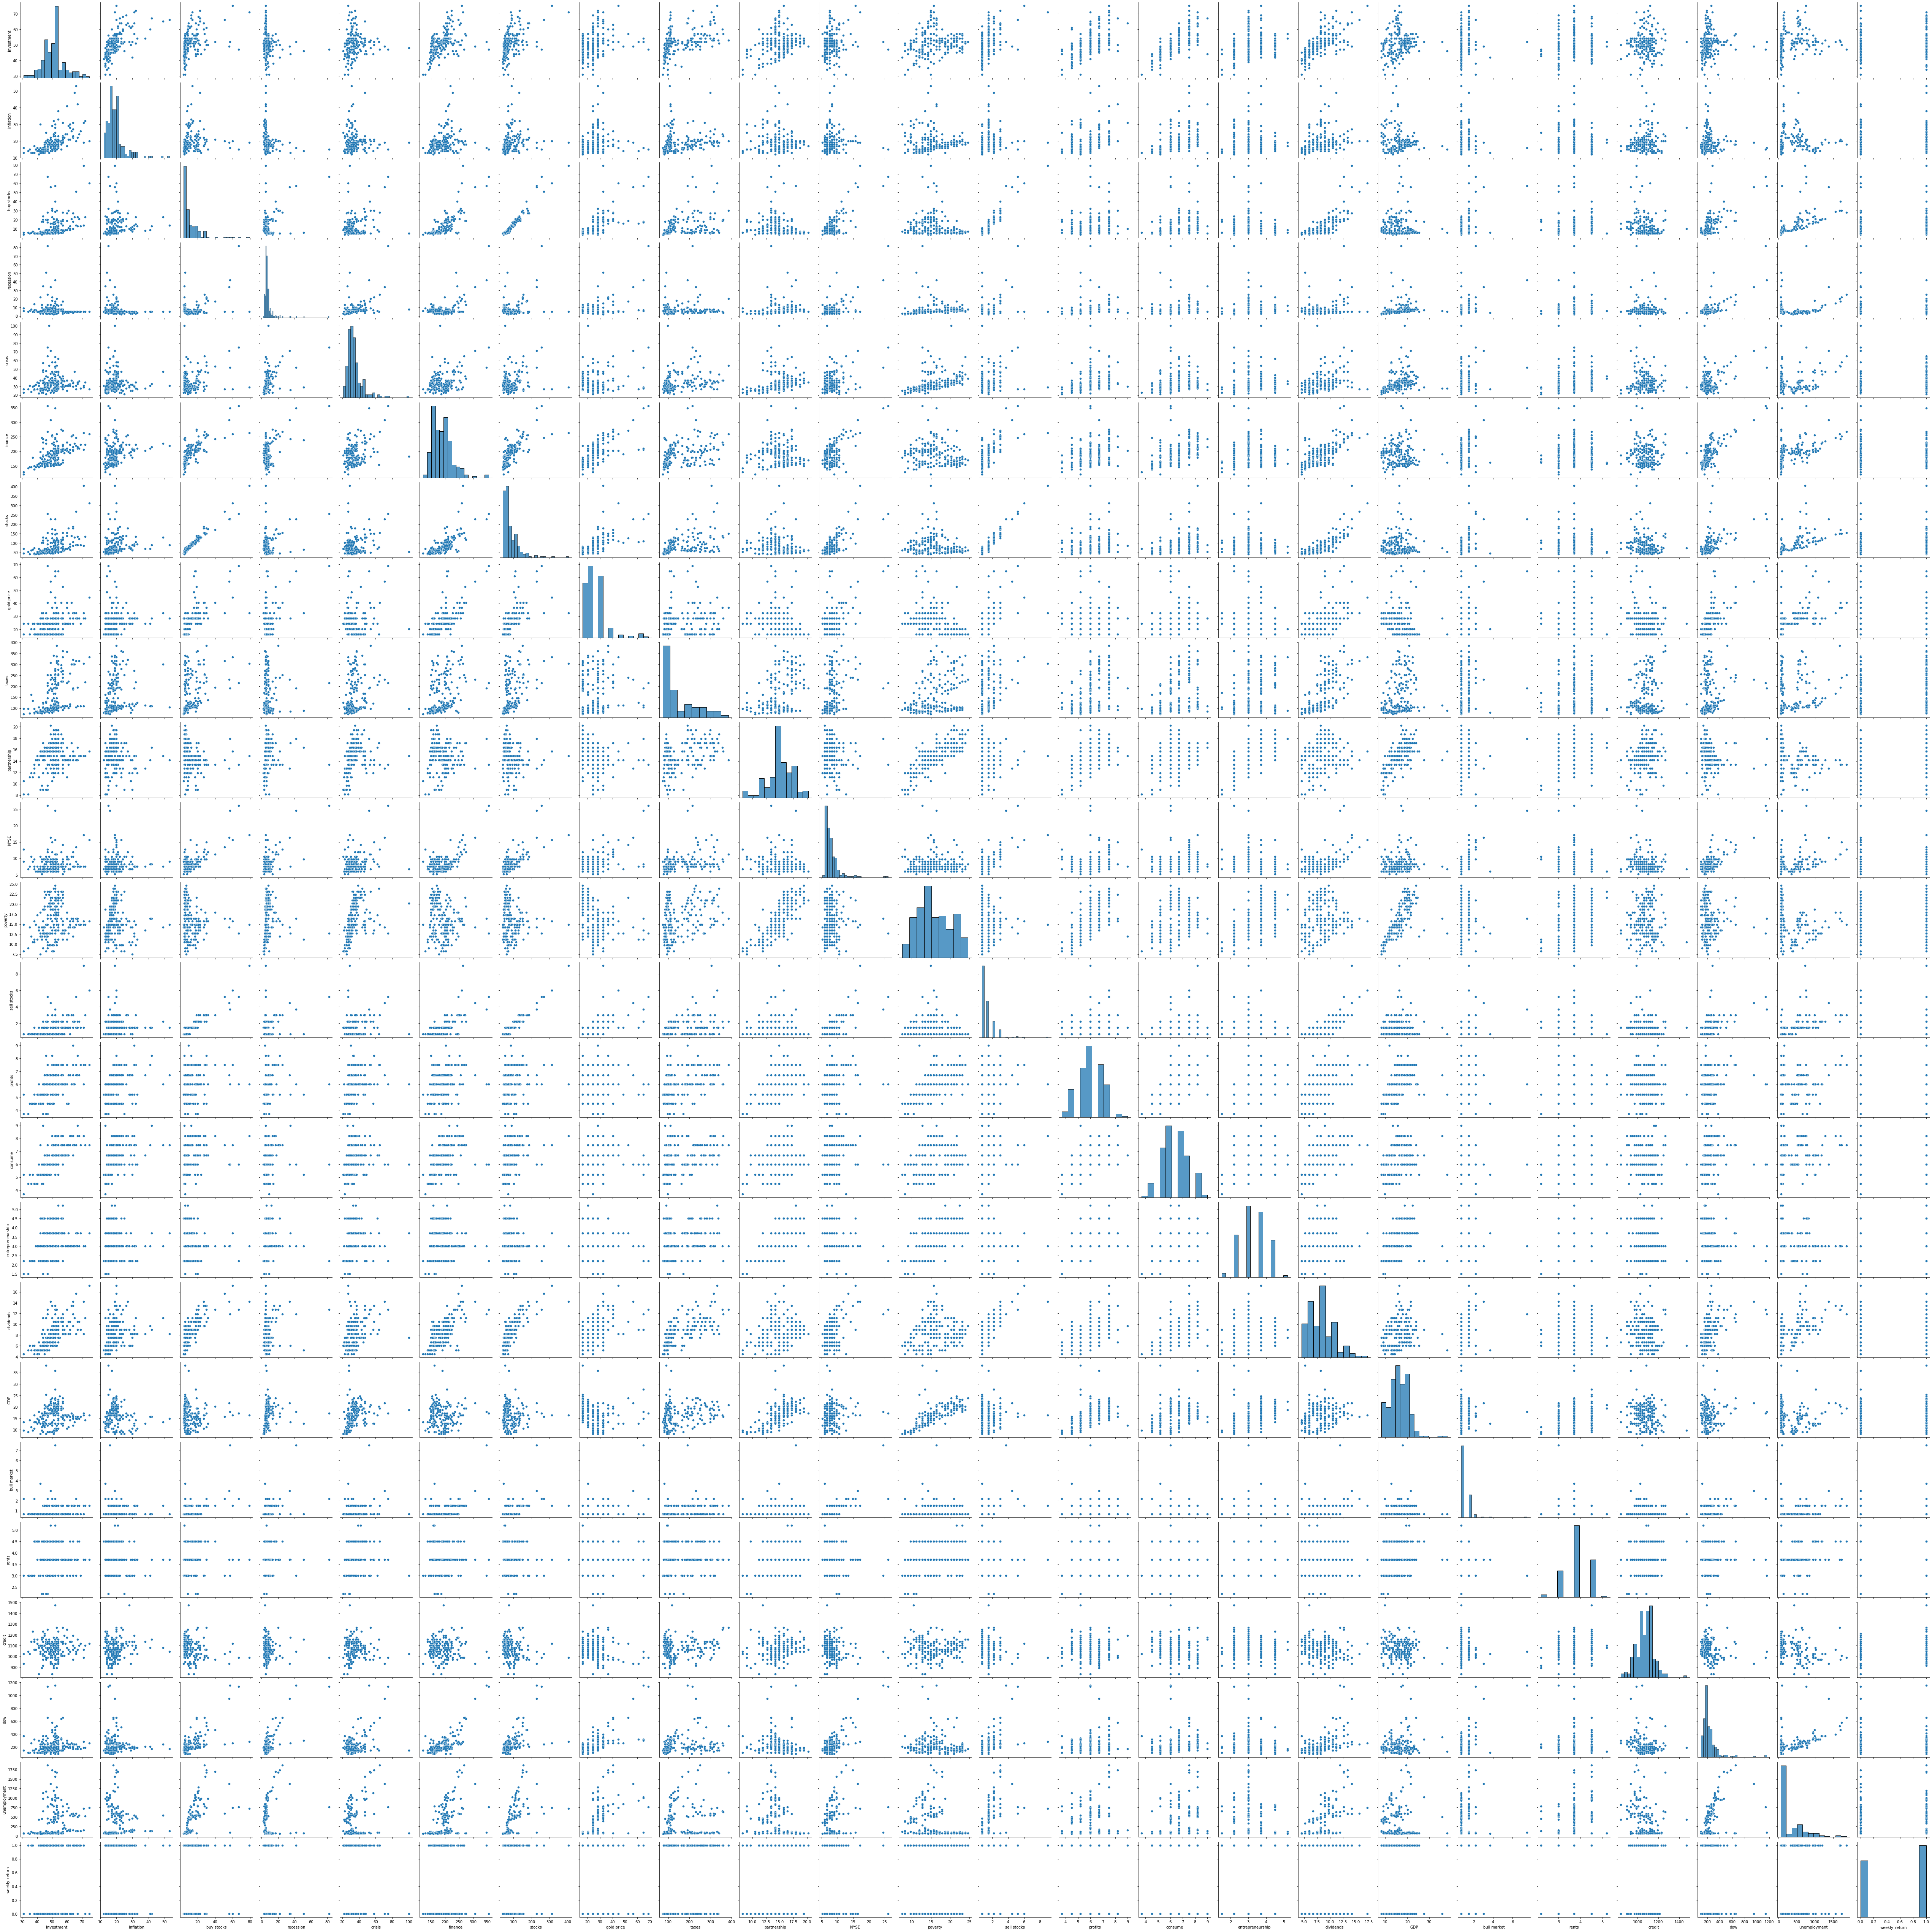

In [219]:
sb.pairplot(data=df_merged, height=3)

kolejne 2 tygodnie

<AxesSubplot:>

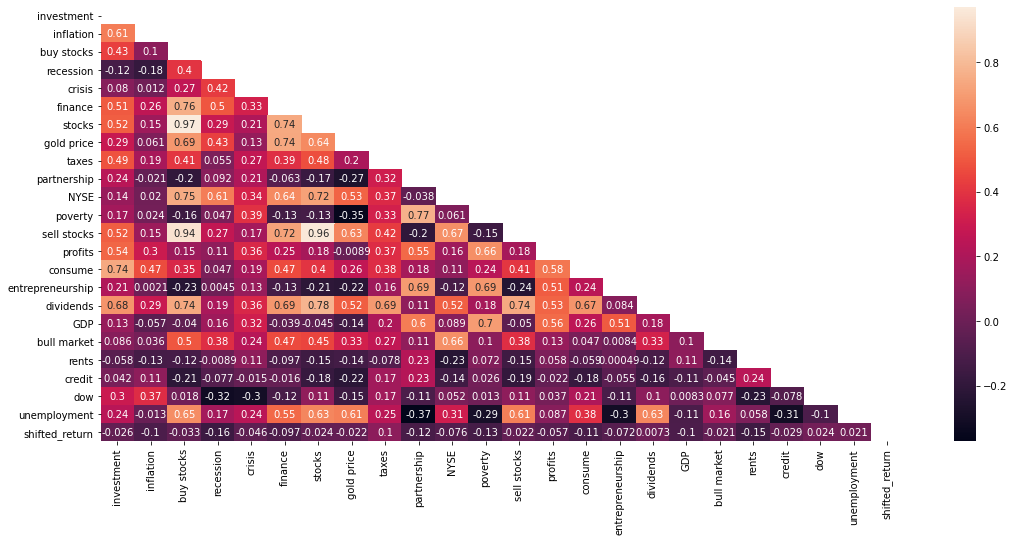

In [31]:
corr_1 = df_shifted.corr(method='pearson')
mask_1 = np.triu(np.ones_like(corr_1, dtype=np.bool))
plt.figure(figsize=(18, 8))
sb.heatmap(corr_1, annot=True, mask=mask_1,
        xticklabels=corr_1.columns,
        yticklabels=corr_1.columns)

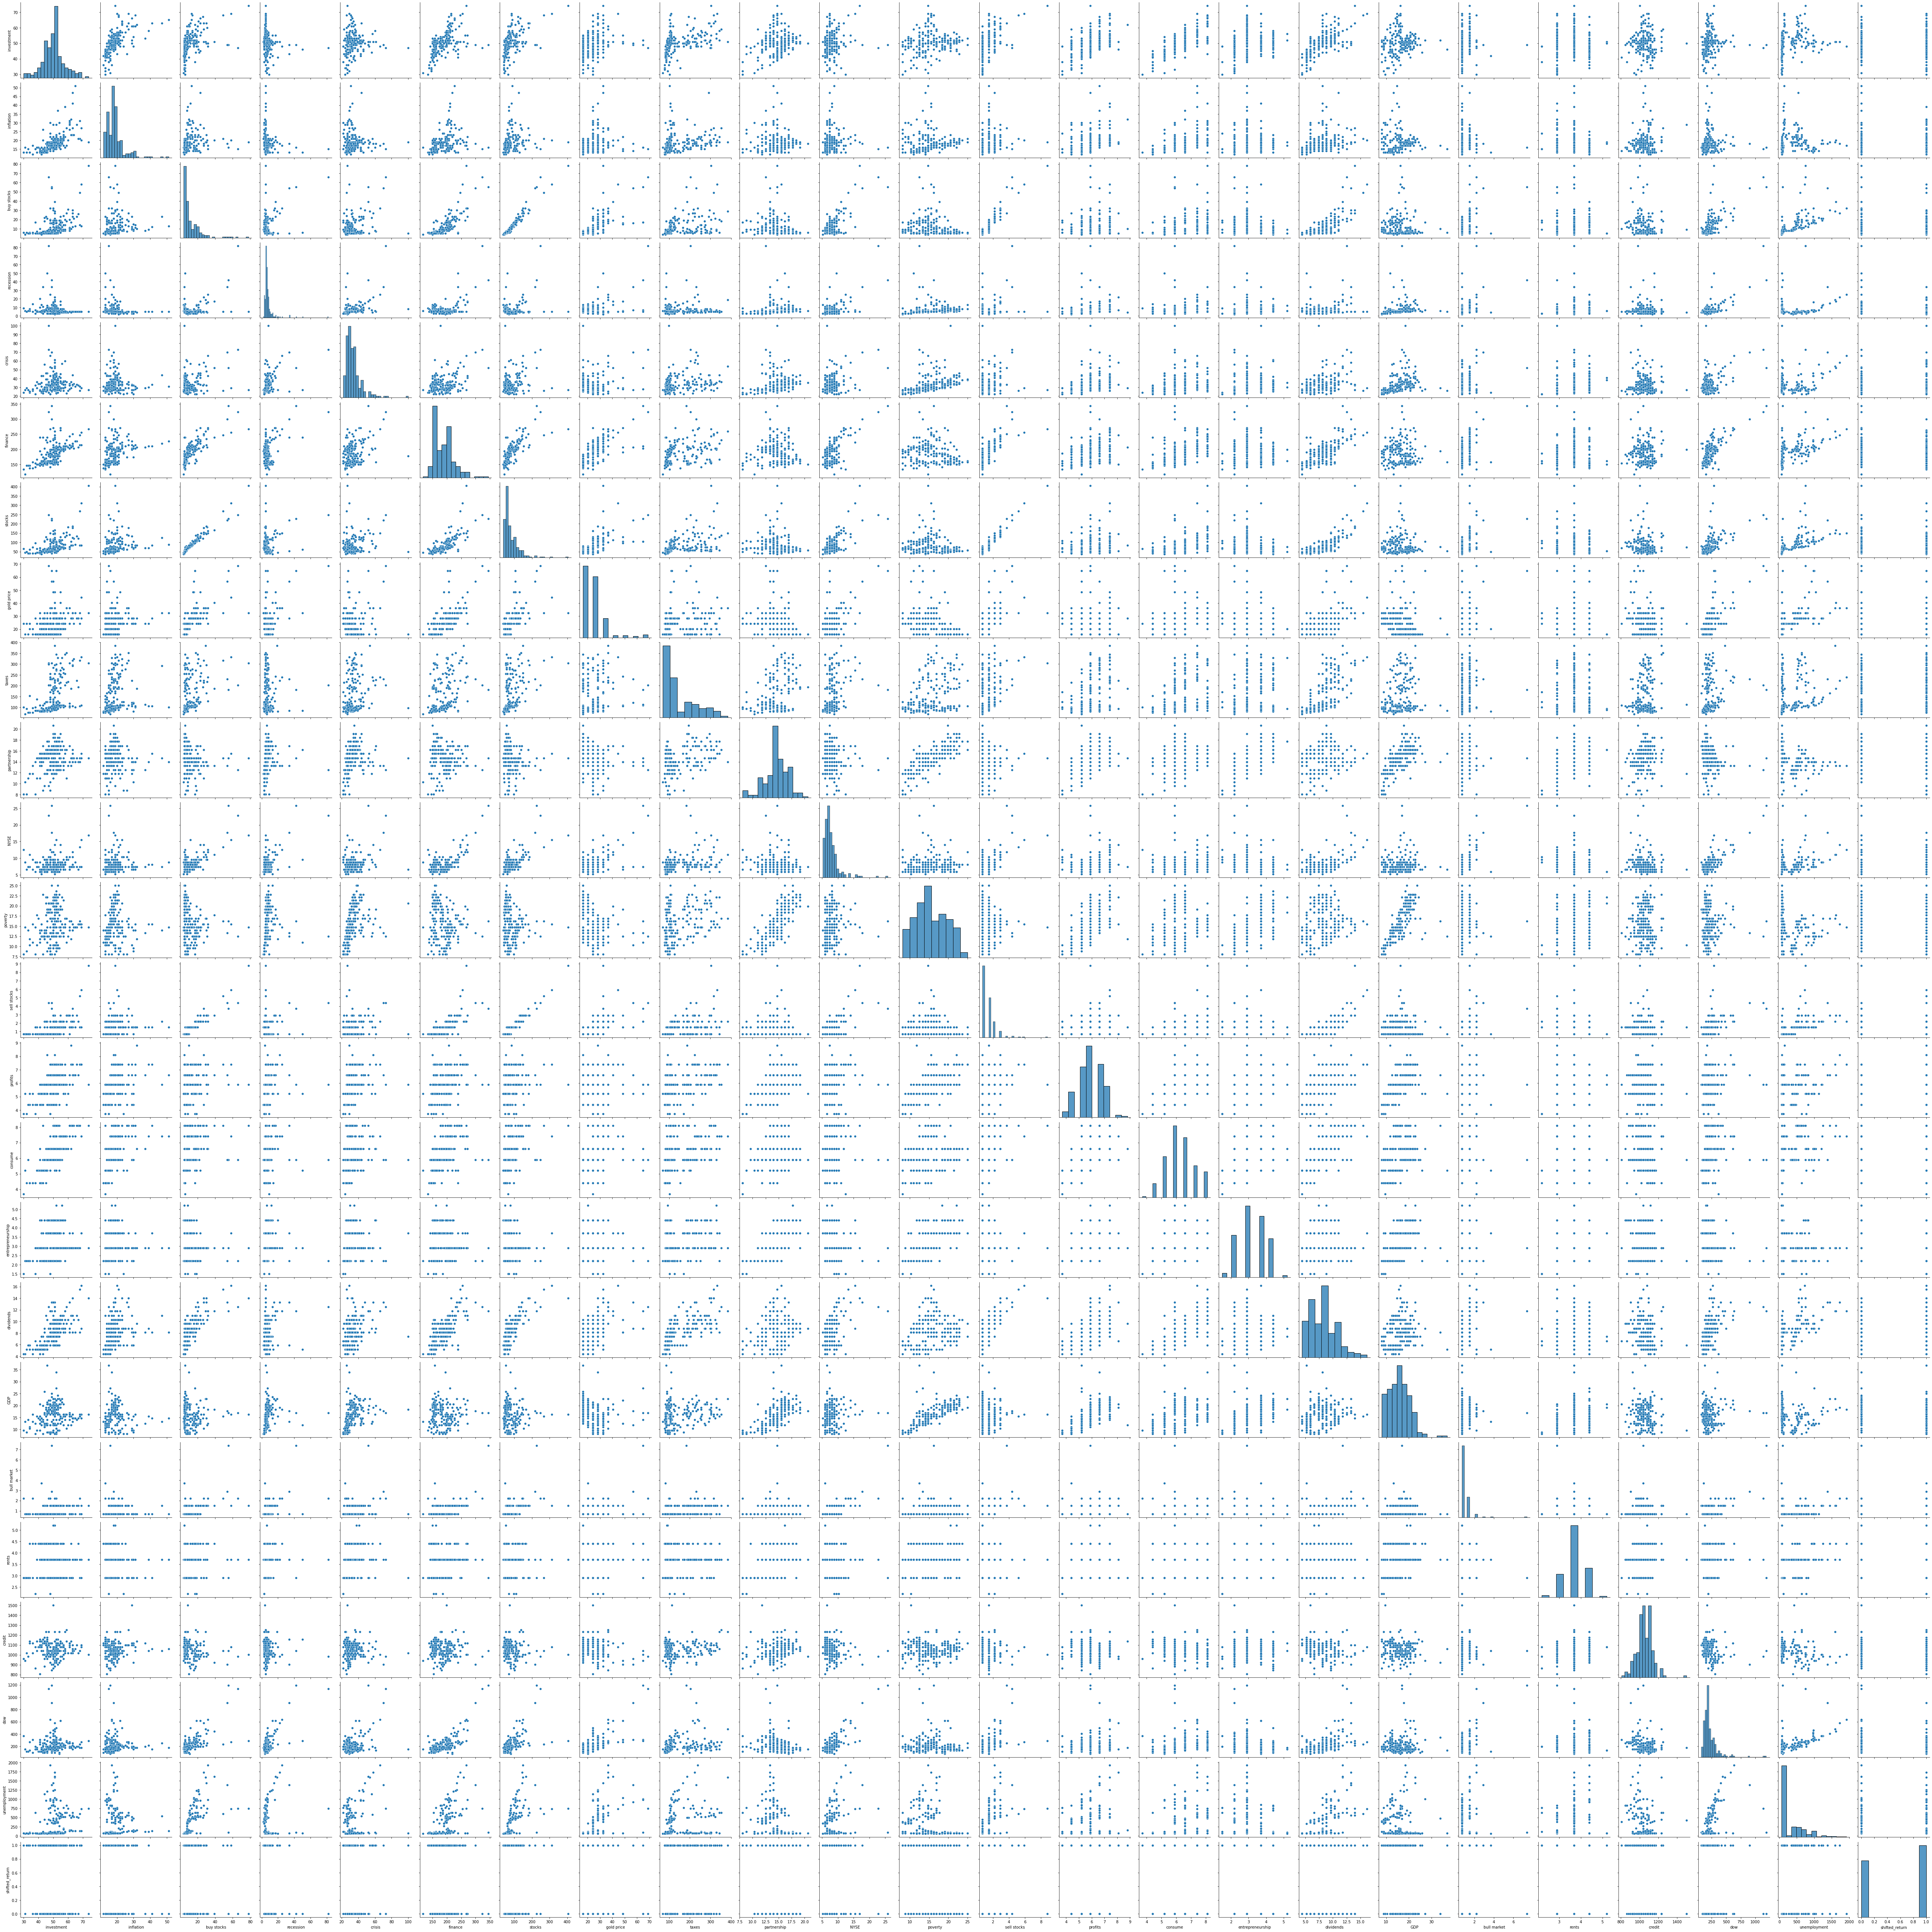

In [221]:
sb.pairplot(data=df_shifted, height=3)

In [ ]:
#https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py
#https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
#https://scikit-learn.org/stable/modules/linear_model.html#lasso
#  fit_transform() on training data ........... transform() on the test
# wyjasnienie teg powyzej https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe

# Model podstawowy, bez przesunięcia tygodnia

#### Podział na zbiór treningowy i testowy

In [217]:
# train test normalne weekly return
X = df_merged.drop(['weekly_return'],axis=1)
y = df_merged['weekly_return']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0, shuffle=False, stratify = None)

In [218]:
print (X_train.shape, X_test.shape)
print (y_train.shape, y_test.shape)

(146, 23) (63, 23)
(146,) (63,)


#### Transformacja danych

In [219]:
# transformacja danych za pomocą PowerTransformer metodą Yeo-Johnsona
ss = StandardScaler()
pt = PowerTransformer(method="yeo-johnson") #może być dla dodatnich i ujemnych wartości, w przeciwieństwie do box-cox
#y_train = PowerTransformer(method="yeo-johnson")
#X_train = pt.fit_transform(X_train)
#X_test = pt.transform(X_test, y_test)
#y_train = pt.fit_transform(y_train)
#y_test = pt.transform(y_test)

X_train_s = pt.fit_transform(X_train)
X_test_s = pt.transform(X_test)

#### Accuracy w zależności od C (odwrotność lambdy) - ustalenie parametru regularyzacji

In [220]:
y_pred=lr.predict(X_train_s)
for i in (x * 0.1 for x in range(1, 10)):
    lr = linear_model.LogisticRegression(penalty='l1', C=i, solver='liblinear', random_state = 0)
    lr.fit(X_train_s, y_train)
    print('C=', i)
    print('Non-zero coefficients:', lr.coef_[lr.coef_!=0].shape)
    print('Training accuracy:', lr.score(X_train_s, y_train))
    print('Test accuracy:', lr.score(X_test_s, y_test))
    #metrics.confusion_matrix(y_test, y_pred=y_pred)
    print('')

C= 0.1
Non-zero coefficients: (1,)
Training accuracy: 0.547945205479452
Test accuracy: 0.5714285714285714

C= 0.2
Non-zero coefficients: (7,)
Training accuracy: 0.636986301369863
Test accuracy: 0.5714285714285714

C= 0.30000000000000004
Non-zero coefficients: (8,)
Training accuracy: 0.6438356164383562
Test accuracy: 0.6031746031746031

C= 0.4
Non-zero coefficients: (12,)
Training accuracy: 0.6643835616438356
Test accuracy: 0.6349206349206349

C= 0.5
Non-zero coefficients: (13,)
Training accuracy: 0.678082191780822
Test accuracy: 0.6349206349206349

C= 0.6000000000000001
Non-zero coefficients: (13,)
Training accuracy: 0.6643835616438356
Test accuracy: 0.6507936507936508

C= 0.7000000000000001
Non-zero coefficients: (17,)
Training accuracy: 0.6712328767123288
Test accuracy: 0.6507936507936508

C= 0.8
Non-zero coefficients: (18,)
Training accuracy: 0.6712328767123288
Test accuracy: 0.6349206349206349

C= 0.9
Non-zero coefficients: (18,)
Training accuracy: 0.6643835616438356
Test accuracy:

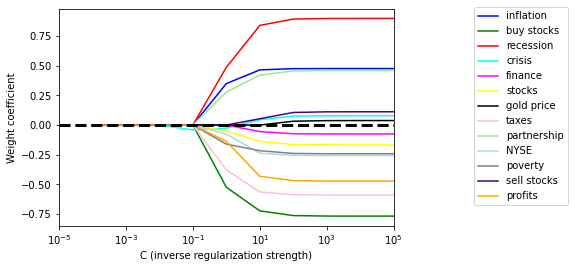

In [246]:
fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, 
                            solver='liblinear', random_state=0)
    lr.fit(X_train_s, y_train)
    weights.append(lr.coef_[0])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_merged.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Współczynniki')
plt.xlabel('C (regularyzacja)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

#### Model z największą accuracy przy c=0,7

In [221]:
lr = linear_model.LogisticRegression(penalty='l1', C=0.7, solver='liblinear', random_state = 0) #0.5 jeśli test=0.3
lr.fit(X_train_s, y_train)
print('Training accuracy:', lr.score(X_train_s, y_train))
print('Test accuracy:', lr.score(X_test_s, y_test))
#pred_model = model.predict(X_test)
'''y_pred = lr.predict(X_test)
#print(lasso.coef_)
plt.scatter(y_test, y_pred)
lr.score(y_test, y_pred)
lr.score()
#confusion_matrix(y_true=y_train, y_pred=model.predict(X_train))'''

Training accuracy: 0.6712328767123288
Test accuracy: 0.6507936507936508


'y_pred = lr.predict(X_test)\n#print(lasso.coef_)\nplt.scatter(y_test, y_pred)\nlr.score(y_test, y_pred)\nlr.score()\n#confusion_matrix(y_true=y_train, y_pred=model.predict(X_train))'

In [147]:
lr.coef_[lr.coef_!=0].shape
print(lr.intercept_)
print(lr.coef_)

array([0.1488335])

In [150]:
log_odds = lr.coef_[0]

df = pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)
df.loc[(df != 0).any(1)]

coef
investment        0.279239
taxes             0.235489
buy stocks        0.204215
credit            0.149137
entrepreneurship  0.063828
profits           0.040014
NYSE             -0.080820
consume          -0.101850
recession        -0.111269
rents            -0.145065
bull market      -0.169945
gold price       -0.218676
inflation        -0.365645

#### Ocena modelu

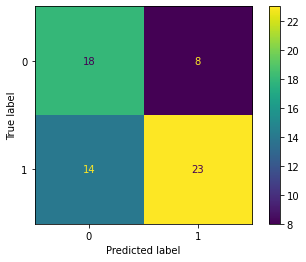

In [222]:
cm = confusion_matrix(y_true=y_test, y_pred=lr.predict(X_test_s))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [227]:
roc_auc_score(y_test, lr.predict(X_test_s))

0.6569646569646569

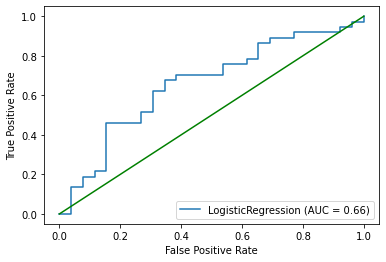

In [235]:
plot_roc_curve(lr, X_test_s, y_test)
plt.plot([0, 1], [0, 1], color = 'g')

Precision:  [0.58730159 0.74193548 1.        ]
Recall:  [1.         0.62162162 0.        ]


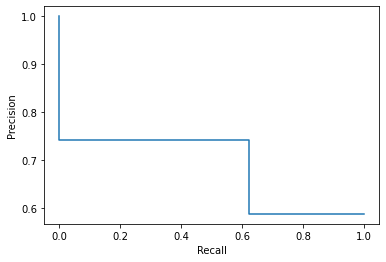

In [234]:
precision, recall, _ = precision_recall_curve(y_test, lr.predict(X_test_s))
print('Precision: ', precision)
print('Recall: ', recall)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
#plot_precision_recall_curve(y_test, lr.predict(X_test_s))

# Shifted model - tydzień wcześniej wyszukiwania

#### Podział na zbiór testowy i treningowy

In [248]:
# train test shifted weekly return
X = df_shifted.drop(['shifted_return'],axis=1)
y = df_shifted['shifted_return']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0, shuffle=False, stratify = None)

#### Transformacja danych

In [249]:
ss = StandardScaler()
pt = PowerTransformer(method="yeo-johnson")
X_train_s = pt.fit_transform(X_train)
X_test_s = pt.transform(X_test)

#### Ustalenie parametru regularyzacji

In [251]:
for i in (x * 0.1 for x in range(1, 10)):
    lr = linear_model.LogisticRegression(penalty='l1', C=i, solver='liblinear', random_state = 0)
    lr.fit(X_train_s, y_train)
    print('C=', i)
    print('Non-zero coefficients:', lr.coef_[lr.coef_!=0].shape)
    print('Training accuracy:', lr.score(X_train_s, y_train))
    print('Test accuracy:', lr.score(X_test_s, y_test))
    #metrics.confusion_matrix(y_test, y_pred=lr.predict(X_train_s))
    print('')

C= 0.1
Non-zero coefficients: (1,)
Training accuracy: 0.5821917808219178
Test accuracy: 0.6190476190476191

C= 0.2
Non-zero coefficients: (6,)
Training accuracy: 0.6438356164383562
Test accuracy: 0.6349206349206349

C= 0.30000000000000004
Non-zero coefficients: (9,)
Training accuracy: 0.636986301369863
Test accuracy: 0.6190476190476191

C= 0.4
Non-zero coefficients: (11,)
Training accuracy: 0.6643835616438356
Test accuracy: 0.6190476190476191

C= 0.5
Non-zero coefficients: (13,)
Training accuracy: 0.684931506849315
Test accuracy: 0.6349206349206349

C= 0.6000000000000001
Non-zero coefficients: (16,)
Training accuracy: 0.678082191780822
Test accuracy: 0.6190476190476191

C= 0.7000000000000001
Non-zero coefficients: (16,)
Training accuracy: 0.684931506849315
Test accuracy: 0.6190476190476191

C= 0.8
Non-zero coefficients: (16,)
Training accuracy: 0.684931506849315
Test accuracy: 0.5873015873015873

C= 0.9
Non-zero coefficients: (18,)
Training accuracy: 0.684931506849315
Test accuracy: 0.

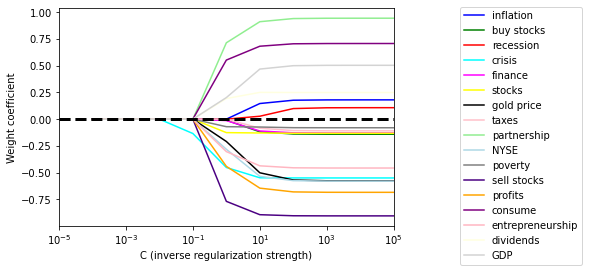

In [254]:
fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange', 'purple',
          'lightpink', 'lightyellow', 'lightgray']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, 
                            solver='liblinear', random_state=0)
    lr.fit(X_train_s, y_train)
    weights.append(lr.coef_[0])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_shifted.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Współczynniki')
plt.xlabel('C (regularyzacja)')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

#### Model z największą accuracy przy c=0,5

In [252]:
lr = linear_model.LogisticRegression(penalty='l1', C=0.5, solver='liblinear', random_state = 0) #0.2
lr.fit(X_train_s, y_train)
print('Training accuracy:', lr.score(X_train_s, y_train))
print('Test accuracy:', lr.score(X_test_s, y_test))
print('Non-zero coefficients:', lr.coef_[lr.coef_!=0].shape)

Training accuracy: 0.684931506849315
Test accuracy: 0.6349206349206349
Non-zero coefficients: (13,)


In [253]:
log_odds = lr.coef_[0]

df = pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)
df.loc[(df != 0).any(1)]

coef
taxes             0.550730
profits           0.394459
entrepreneurship  0.109075
dow              -0.028764
credit           -0.041556
NYSE             -0.054330
finance          -0.111941
partnership      -0.144150
rents            -0.169755
consume          -0.205171
sell stocks      -0.292377
recession        -0.356105
poverty          -0.585954

#### Ocena modelu

In [205]:
lr.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

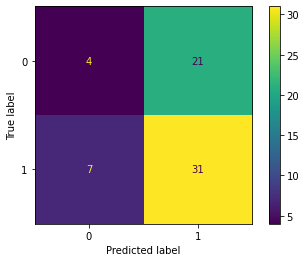

In [257]:
cm = confusion_matrix(y_true=y_test, y_pred=lr.predict(X_test_s))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [258]:
roc_auc_score(y_test, lr.predict(X_test_s))

0.48789473684210527

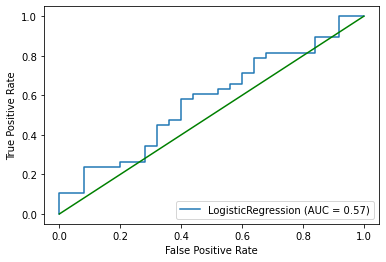

In [259]:
plot_roc_curve(lr, X_test_s, y_test)
plt.plot([0, 1], [0, 1], color = 'g')

Precision:  [0.6031746  0.59615385 1.        ]
Recall:  [1.         0.81578947 0.        ]


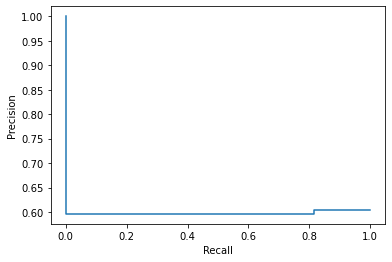

In [260]:
precision, recall, _ = precision_recall_curve(y_test, lr.predict(X_test_s))
print('Precision: ', precision)
print('Recall: ', recall)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()